In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"


# Feature selection done by Conditional Inference Trees 

CIT uses p-value as one-a-split criterion instead of using homogeneity. The algorithm will pick the feature with the least p-value and will start splitting from it. Then it will keep going until it no longer finds statistically significant p-value or some other criteria have met such as minimum node size or max split. 

In [22]:
import sys
import numpy as np
import pandas as pd
import pickle

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

sys.path.insert(0, "../../")
import utils.utils_feature_selection as fs
import utils.settings as s
import utils.utils_evaluation as e

s.init()
seed = s.seed


pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

# import warnings
# warnings.filterwarnings('ignore')

%matplotlib inline

# ruff check ./model_preprocessing/Feature_selection/utils_feature_selection.py --fix

<Figure size 2000x1000 with 0 Axes>

## Load R packages to process Conditional Random Forest in python
*Note 1: all needed R packages have to be previously loaded in R*

*Note 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*

In [3]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
import rpy2.robjects.packages as rpackages


# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats = importr("stats")

# pandas.DataFrames to R dataframes 
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()


# get libraries for CIT processing, ctree_controls etc
#partykit = importr('partykit')
party = importr('party')
caret = importr('caret') # package version >=
#stablelearner = importr('stablelearner')
ggplot2 = importr('ggplot2')


### input data

In [4]:
df_candidates = pd.read_excel("../../input_survey_data/input_data_business.xlsx")
print(df_candidates.shape)
df_candidates.tail(2)


(397, 61)


,Target_contentloss_euro,Target_businessreduction,inundation_duration_h,water_depth_cm,contaminations.0,contaminations.1,contaminations.2,contaminations.3,contaminations.4,flowvelocity,warning_time_h,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.6,emergency_measures.7,emergency_measures.8,emergency_measures.9,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,elevation_building_height_cm,elevation_rel2surrounding_cat,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_finance_investments,shp_suppliers_location.1,shp_suppliers_location.2,shp_suppliers_location.3,shp_suppliers_location.4,shp_suppliers_location.5,shp_profits_last5years,shp_risk_tolerance,shp_monetary_resources4prevention,resilience_city_protection,resilience_more_future_affected,resilience_govern_warnings_helpful,resilience_govern_careing,resilience_govern_careing_increases,resilience_left_alone,resilience_neighbor_management,perception_who_responsible4protection.Rank1,perception_who_responsible4protection.Rank2,perception_govern_support_past,perception_govern_support_future,perception_private_economy_future,shp_content_value_euro,shp_registered_capital_euro,elevation_m
395,0.0,NaN,4.0,70.0,0,1,0,0,1,1,NaN,1,0,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,70.0,1,NaN,130.0,NaN,1,17,2,3,1,1,1,0,0,0,4.0,3.0,3.0,1.0,5.0,1.0,1.0,1.0,5,1.0,2.0,2.0,NaN,1.0,3.0,NaN,11047.7,1.83886
396,0.0,0.0,3.0,100.0,0,1,0,0,1,1,NaN,1,0,1,0,0,0,0,0,0,1,5,5,5,5,5,5,4,NaN,0,5.0,33.0,1.0,1,11,2,3,1,1,1,0,0,0,4.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,5,NaN,3.0,2.0,NaN,NaN,3.0,NaN,736.5,1.87277


In [5]:
targets = ["Target_contentloss_euro", "Target_businessreduction"]
target = targets[0]

## TODO make entire wokflow as loop over both target variables
# ## iterate over both targets and store results 
# for target in ["Target_contentloss_euro", "Target_businessreduction"]:

#     print( f"Apply Elastic Net on {target}:\n")
#     y = df_candidates[target]

In [6]:
## delete features with more than 10% missing values
print("Percentage of missing valeus per feature\n", df_candidates.isna().mean().sort_values(ascending=False)[:15] ) 

# print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))
df_candidates = df_candidates[df_candidates.columns[df_candidates.isna().mean() < 0.10]]  # drop feautres with more than 10% missing values
print(df_candidates.isna().sum(axis=0).sort_values(ascending=False))

## --> drop content values if threshold == 15%

Percentage of missing valeus per feature
 warning_time_h                                 0.775819
perception_who_responsible4protection.Rank2    0.392947
perception_govern_support_past                 0.382872
perception_govern_support_future               0.342569
elevation_building_height_cm                   0.158690
shp_content_value_euro                         0.156171
resilience_govern_careing_increases            0.136020
shp_registered_capital_euro                    0.118388
Target_businessreduction                       0.090680
perception_who_responsible4protection.Rank1    0.070529
shp_risk_tolerance                             0.070529
bage                                           0.068010
perception_private_economy_future              0.065491
hh_monthly_income_cat                          0.060453
resilience_govern_careing                      0.057935
dtype: float64
Target_businessreduction                       36
perception_who_responsible4protection.Rank1    28
shp

In [7]:
## remove records where target information is missing
df_candidates = df_candidates[ ~df_candidates[f"{target}"].isna()]
print(df_candidates.shape)

X = df_candidates.drop(targets, axis=1)
y = df_candidates[target]


## TEST: replace nan with median of each variable
for c in X.columns:
    X[c].fillna(X[c].median(), inplace=True)

(386, 53)


#### Split Data

In [8]:
## test train split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, 
    random_state=seed, shuffle=True
)

# normlaize via MinMaxScaler, transform X_train ,then use the fitted scaler for X_test
X_train, X_test = fs.normalize_X(X_train, X_test)

train = pd.concat([y_train.reset_index(), X_train], axis=1).drop("index", axis=1)
test = pd.concat([y_test.reset_index(), X_test], axis=1).drop("index", axis=1)

### Model fit

In [9]:
# from rpy2.robjects.conversion import localconverter

# # Convert a Pandas DataFrame to an R DataFrame
# def pandas_to_r_dataframe(df):
#     with localconverter(robjects.default_converter + pandas2ri.converter):
#         r_dataframe = robjects.conversion.py2rpy(df)
#     return r_dataframe

# # Convert the Pandas DataFrame to an R DataFrame
# data_train_r = pandas_to_r_dataframe(train)
# x_train_r = pandas_to_r_dataframe(X_train)
# x_test_r = pandas_to_r_dataframe(X_test)
# y_train_r = pandas_to_r_dataframe(y_train)

# # Convert Pandas DataFrame to R list
# y_train_l = robjects.r.list(**dict(zip(y_train_r.names, y_train_r)))
# column_names = " + ".join(X_train.columns)
# #formula = robjects.Formula(f'{target} ~ ' + column_names)

In [17]:
##  CV with gridSearch from R 
## Due that cforest is a R package it only accepts other R functions for tunning and cross validation  
## CIT handles by default missing values in response, while CRF doesnt accept missing vlaues in response

# ## Define the hyperparamters
## NOTE: cant define hyperparameter ranges for cforest, caret.train(method="cforest") is doing this by itself
## train() Doc: https://search.r-project.org/CRAN/refmans/caret/html/train.html


base.set_seed(seed)
## CV method
fitControl = caret.trainControl(
    method = "repeatedcv",  # "oob" - then no repeats are needed
    number = 10,   ## = K-folds
    repeats = 10,  # number of tried values for mtry
    )

# robjects.r('''
#         r_grid <- function(verbose=FALSE) {
#             expand.grid(ntree=10)
#         }
#     ''')
# f = robjects.globalenv['r_grid']
# createCfGrid = base.expand_grid(controls = party.cforest_control(mtry=3, ntree=200)) #qnorm() =90th percentile
# mincriterion=stats.qnorm(0.9) # = default
# " train() will generate the grid for you. If you want to specify ntree you just pass a controls object in as another argument to train but leave out mtry:""
# https://stackoverflow.com/questions/20337137/run-cforest-with-controls-cforest-unbiased-using-caret-package?rq=4


## CIT handles by default missing values in response, while CRF doesnt accept missing vlaues in response
base.set_seed(seed)
crf_cv = caret.train(
        Formula(f'{target} ~ .'), 
        data = train,
        method = "cforest",
        metric='RMSE',  # RMSE unit of target or use MAE due that more robust than RMSE further metrics options Rsquared, RMSE, MAE 
        #na_action =  stats.na_pass,
        controls = party.cforest_control( #cforest_unbiased(
            # only mtry gets tuned by grid
            ntree = 100,  # didnt improved with 200 or 500 trees
           # mincriterion = 0.5
        ),  # cforest_unbiased= subsampling without replacement
        trControl = fitControl,
        #tuneGrid = #params_grid, # createCfGrid
        #verbose = False
    )
print(crf_cv) # 5687.575

base.warnings()

Conditional Inference Random Forest 

328 samples
 51 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 296, 296, 295, 296, 294, 295, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   2    5687.575  0.1260149  1811.999
  26    6375.596  0.2382460  1743.448
  51    6946.415  0.2052204  1769.673

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 2.



<rpy2.rinterface_lib.sexp.NULLType object at 0x0000026FD320C340> [RTYPES.NILSXP]

In [11]:
## evalution results of the three tested models during CV and tunning
fs.r_models_cv_results(crf_cv)


,,mtry,RMSE,Rsquared,MAE,...,RsquaredSD,MAESD
0,1,2.0,5687.574940943739,0.1260148923850948,1811.9992256558842,...,0.16754252497051955,1934.6006358503655
1,2,26.0,6375.595666379543,0.23824602561802843,1743.44801970933,...,0.27226427099291883,1956.819655289612
2,3,51.0,6946.4149030741955,0.20522041997898266,1769.673029648624,...,0.2875557356522496,1980.5731680218225


In [24]:
## store trained model for evaluation
filename = f'./models_trained/crf_{target}'
pickle.dump(crf_cv, open(filename, 'wb'))


In [25]:
## get best model

#print(crf_cv.names)#$param
best_hyperparameters = fs.r_best_hyperparamters(crf_cv)
best_hyperparameters = fs.r_dataframe_to_pandas(best_hyperparameters)
print(best_hyperparameters)

   mtry
1   2.0


In [26]:
## refit model with best hyperparamters
#cit_model = partykit.ctree(Formula(f'{target} ~ .'),  
crf_model = party.cforest(Formula(f'{target} ~ .'),  
                                data=train,
                                #control= party.cforest_control(mtry=best_hyperparameters.mtry, ntree=100)
                                control= party.cforest_unbiased(mtry=best_hyperparameters.mtry, ntree=100)
                                #control = partykit.ctree_control(mincriterion = 0.8)
                          )
print(crf_model)


	 Random Forest using Conditional Inference Trees

Number of trees:  100 

Response:  Target_contentloss_euro 
Inputs:  inundation_duration_h, water_depth_cm, contaminations.0, contaminations.1, contaminations.2, contaminations.3, contaminations.4, flowvelocity, emergency_measures.1, emergency_measures.2, emergency_measures.3, emergency_measures.4, emergency_measures.6, emergency_measures.7, emergency_measures.8, emergency_measures.9, overall_problem_house, protect_valuables_impl, water_barriers_impl, pumping_equipment_impl, elevation_building_impl, resistant_material_building_impl, electricity_higher_impl, flood_protections_impl, flood_experience, elevation_rel2surrounding_cat, bage, b_area, hh_monthly_income_cat, shp_owner, shp_sector, shp_employees, shp_avgmonthly_sale_cat, shp_finance_investments, shp_suppliers_location.1, shp_suppliers_location.2, shp_suppliers_location.3, shp_suppliers_location.4, shp_suppliers_location.5, shp_profits_last5years, shp_risk_tolerance, shp_monetary

## Model evaluation

In [27]:
crf_model_p = pickle.load(open(f"./models_trained/crf_{target}", 'rb'))
type(crf_model_p)
#cit_model_p.__dir__()


rpy2.robjects.vectors.ListVector

In [30]:
## Predict
y_pred = stats.predict(crf_model, newdata=X_test)#, type="response") #  type = "prob" # conditional class probabilities extractPrediction(
y_pred  = base.round(y_pred)

## get back to python dtypes
y_pred = np.array(y_pred)
y_test = np.array(y_test)

## print evlaution report + check for ovrfitting 
print("\nTesting set")
e.evaluation_report(y_test, y_pred)

y_pred_train = np.round(stats.predict(crf_model, newdata=X_train), 1).reshape(-1)
print("\nTraining set")
e.evaluation_report(y_train, y_pred_train)


Testing set

    Model Performance:
        Mean Squared Error: 2244484.3
        Root Mean Square Error: 1498.2
        Mean Absolute Error: 1084.6
        Mean Absolute Percentage Error: inf
        R²-Score: -5.2
    


c:\Users\Anna\Documents\UNI\MA_topic\flood-loss-models-4-HCMC\develop\model_preprocessing\Feature_selection\../..\utils\utils_evaluation.py:14: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100



Training set

    Model Performance:
        Mean Squared Error: 137357219.6
        Root Mean Square Error: 11719.9
        Mean Absolute Error: 1803.8
        Mean Absolute Percentage Error: inf
        R²-Score: 0.1
    


(137357219.61493903,
 11719.949642167368,
 1803.7865853658536,
 inf,
 0.13176155798569533)

In [141]:
   
Training set score (R^2, MAE): (0.1, 1704.2)
Testing set score (R^2, MAE): (-4.6, 1004.1)

(328, 51)

## Feature importance

In [97]:
## Code snippet from Danielas CRF script and from https://cran.r-project.org/web/packages/stablelearner/vignettes/forests.html

## Calculate variance importance based on selection frequency
# varimp = party.varimp(model, measures=["freq"])
# varimp_df = pd.DataFrame({'Variable': varimp.names, 'Importance': varimp})
## Sort the variable importance in descending order
# varimp_df = varimp_df.sort_values(by='freq', ascending=False)
## Plot the variance importance
# varimp_df.plot(kind='bar', x='term', y='freq', figsize=(10, 6))

# Extract variable importance values from the model
varimp = party.varimp(crf_model, conditional = True )  # compute conditional variable importance scores
# t = caret.varImp(crf_model)#, conditional=True) # caret derives FI a bit differently than party package
# pd.DataFrame({"names":X.columns.to_list(), "importances":pd.Series(t)[0]}).sort_values("importances", ascending=False).head(5)

## define threshold
## Hilpert 2020: The rule of thumb is to take the absolute minimum value as a cutoff point. 
np.abs(np.min(varimp))

50486.27825910289

In [95]:
## TODO -DONE use abs() version : check if abs value of negative importances from CRF should be used
## Hilpert 2020: "Note that unimportant predictors fluctuate randomly around zero, with positive or negative values
## "Negative values appear when the randomly permuted versions of a predictor tend to be better than the original one."
## --> means: negative FI score indicate important features. 
varimp = np.abs(varimp)
df_importance = pd.DataFrame({
    "importances" : varimp, 
    }, index= X.columns.to_list())

#df_importance = df_importance.loc[df_importance.importances > importances_threshold[target], : ].T      # drop features which dont reduce the loss


df_importance = df_importance.sort_values("importances", ascending=False)
df_importance.head(5)

,importances
shp_risk_tolerance,94921.913725
elevation_rel2surrounding_cat,85338.441521
shp_employees,63970.103838
protect_valuables_impl,55014.565848
pumping_equipment_impl,52336.947985


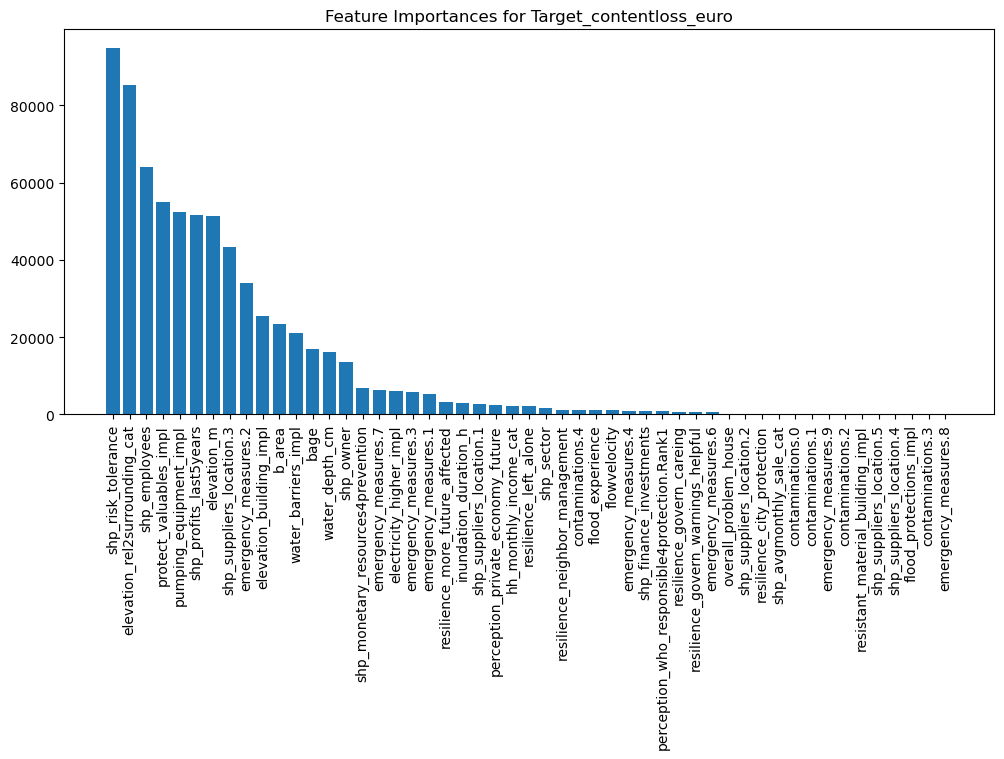

In [96]:
# plot feature importance
fig, ax = plt.subplots(figsize=(12,5))


# keep only features which reduce the loss
#df_importance = df_importance.loc[df_importance.importances > 0, : ]

plt.bar(df_importance.index, df_importance.importances)
plt.xticks(
    #ticks = range(len(selected_feat)),
    #labels = X_unscaled.iloc[:,selected_feat],
    rotation = 90
    )
plt.title(f"Feature Importances for {target}")

plt.show()

In [ ]:
y_train.shape

(289,)

In [141]:
## get signifcant features
selected_feat = cit_stats.loc[:, cit_stats.loc["p_value",:]<= 0.05]

## write selected predictors to disk
fs.save_selected_features(X_train, pd.DataFrame(y_train), selected_feat.columns, filename=f"../../input_survey_data/fs_cit_{target}.xlsx")


selected features: 10
dropped features: 49
selected features: 
['b_area', 'hh_monthly_income_cat', 'shp_sector', 'shp_employees', 'shp_avgmonthly_sale_cat', 'shp_suppliers_location.3', 'shp_suppliers_location.4', 'perception_who_responsible4protection.Rank1', 'shp_content_value_euro', 'shp_registered_capital_euro']

Saving model to disk: ../../input_survey_data/fs_cit_Target_contentloss_euro.xlsx


#### Statistics related to CIT and CRF

The log rather than the p-value is used because it is numerically much more stable when used for comparisons, computing the minimal value, etc. Note that the p-values can become extremely small when significant. 


statistic DEF: 

citrerion DEF: 



In [ ]:
## Snippet from: https://cran.r-project.org/web/packages/stablelearner/vignettes/forests.html
# cf_stablelearner = stablelearner.stabletree(cit_model,
#   sampler = stablelearner.subsampling, savetrees = True, B = 100, v = 0.632)
# #Internally, stablelearner::stabletree() does the following: For each of the 100 trees to be generated, the dataset is resampled according to the resampling method specified (in our case subsampling with a fraction of v = 0.632) and the function call of our initial tree (which we labeled ct_partykit) is updated with respect to this resampled data and reevaluated, resulting in a new tree. All the 100 trees together then build the forest.

# #2.2 Gaining insight into the forest
# #The following summary prints the variable selection frequency (freq) as well as the average number of splits in each variable (mean) over all 100 trees. As we do not want to focus on our initial tree (remember that we just grew a forest, where all trees are of equal interest), we set original = FALSE, as already mentioned in the introduction:
# t = base.summary(cf_stablelearner, original = False)

# ## Variable selection overview:
# ## Note: n python we can see the R df.index which contains the variable names, therefore it is not very usefull
# #pd.DataFrame(t).iloc[3,:][0] # frequency
# #pd.DataFrame(t).iloc[3,:][1] # mean
# #print(X.columns[:23])

In [ ]:
# ## actual p-values (without log)
# strucchange = importr("strucchange")
# strucchange.sctest(cit_model, node = 1)[1]  # p values

In [64]:
cit_model_p.rx(3)

R[write to console]: Error in character_split(split_node(x), data = data, digits = digits,  : 
  unused argument (useS4 = FALSE)



0,3,[1]...
1,4,...
2,5,...
3,6,Target_co...
4,7,['3' '4'...
5,8,$call (fu...


In [50]:
cit_model_p.names
cit_model_p = np.array(cit_model_p.rx(3))
cit_model_p

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (6,) + inhomogeneous part.